# Analysis of Steam achievements dataset

This Notebook is dedicated to the analysis of the dataset of the steam achievements provided from kaggle (https://www.kaggle.com/datasets/patrickgendotti/steam-achievementstatscom-rankings). The first step is to do a basic data descriptions after the data is imported.

## 1. Data Understanding
### 1.1 Data import
General imports for data analysis and the actual dataset import. The dataFrame `achieve_df` represents the achievement progress of the top 200k steam users. The `country_df` represents the data aggregated to the countries.

In [245]:
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.parser import parse
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [246]:
achieve_df = pd.read_csv("amended_first_200k_players.csv")
country_df = pd.read_csv("country_data.csv")

### 1.2 Description of the Player dataset

Let's start with the description of the `achieve_df`. This df ranks the first approx. 200k by their achievements. What information we get is described in the next cells by looking at the different columns.

In [247]:
achieve_df

,Unnamed: 0,Rank,Player Id,Player Name,Best achievements,Points,#,Games,100%,All,Badges,XP,Member since,Hours,Last update
0,0,1,The Stranger,The Stranger,Blessing of the Flame Requiescat Memory Awak...,132759.30,153732,16755,4493,21203.0,4910,3087192,04/15/2011,75591.8,05/26/2022 11:41:05
1,1,2,lylat,lylat,"Death from Above Apex Predator Waste Not, Wa...",119588.95,141645,18358,6034,28377.0,195,296822,06/03/2009,55960.7,05/26/2022 11:42:01
2,2,3,hannez,hannez,Legendary Heckler Legendary Storm Legendary ...,96014.25,98255,13651,4008,23981.0,2009,792032,06/23/2010,33020.0,05/26/2022 11:40:54
3,3,4,DDtective,DDtective,Escaping Outlands A Duneman's Promise Elite ...,89515.41,101757,12070,3708,19821.0,196,60662,09/01/2005,9352.9,07/22/2022 23:39:26
4,4,5,Skaery,Skaery,World of Easy Goo World of Okay Goo World of...,88175.83,95676,10338,2127,13092.0,645,198956,06/08/2004,89602.9,05/26/2022 11:38:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200005,199975,200006,76561198085421589,Brandenburg800,['1v1 Ranked (all I got was stomped and this l...,467.61,642,112,1,170.0,12,1852,03/03/2013,1544.3,06/05/2022 19:40:30
200006,199976,200007,76561198403437459,bounce01,['Who Need A Mechanic? (Besiege – 1.92 points)...,467.61,857,102,2,131.0,7,783,07/11/2017,2750.9,06/06/2022 20:56:55
200007,199977,200008,76561198015047677,awake,"[""I'm Flying! (Drake Hollow – 2.00 points)"", '...",467.61,908,190,1,256.0,125,31466,11/01/2009,0.0,05/21/2022 23:19:50
200008,199978,200009,76561198832353988,depressed fearless,"['Welcome to Arid (Unturned – 2.15 points)', '...",467.60,767,60,0,43.0,8,4946,04/25/2018,1512.8,04/24/2022 10:35:30


As shown in the output above, the df has 15 columns which can be described as followed:
- **Unnamed: 0**: Probably an indexing column. Kinda confusing since it resets  to 0 after 29 and then indexes again. After looking at the git repo the first 30 are the top 30 displayed on the website the data is scrapped from. There is even a TODO in the data scrapping notebook to fix the formatting of the columns of the added top 30. This also explains further issues with these entries.
- **Rank**: The ranking order of the player. The player is most likely ranked after the `Points` column.
- **Player Id**: The Unique ID (Steam ID) of the players. The ID can be set by the player himself or is a 17-digit number in most cases.
- **Player Name**: Individual Player name.
- **Best achievements**: This list generally represents the best achievements gained. Usually an array for each player that holds the best achievements in regard to how many points were gained through the achievement. The entries before the reset in column `Unnamed: 0` have only returns a String. It looks like the array here is converted to a string already. It also has no points. If a profile is private the row contains the entry *private profile*.
- **Points**: The Points represent the points gained through getting an achievement. Based on the `Best achievements` column, each achievement as individual points. This could be based on the difficulty of the achievements.
- **#**: There is no information given to the column. My best guess is that this represents the amount of achievements gained by each player. Still, this could be anything else. After looking at the profiles on the achievementstats.com website. It cleared up, that this is indeed the amount of achievements gained.
- **Games**: The amount of games owned by the player.
- **100%**: The amount of games that are completed to a 100%. This usually means that every achievement is received.
- **All**: I am guessing that this represents the amount of games + the DLC and other extensions for games.
- **Badges**: The amount of badges earned by the player. A Batch is earned by gaining trading cards for a game. N-amount of trading cards result in a badge, which can be displayed on a steam profile.
- **XP**: Total amount of Steam XP gained.
- **Member since**: The creation date of the steam account.
- **Hours**: The hours the user played the games owned.
- **Last Update**: Most likely the time the entry is last update on the website and by this how old the entry is.

Next step is to look at different statistical values to get an overview about the data that is stored in the different columns. I like to use the `describe()` function for that, even though this aggregates all columns and some of them are useless to be aggregated, but still it is one of the easiest methods for calculating these values. Also, we look at the missing values and check for some multiple values.

In [248]:
achieve_df.describe()

,Unnamed: 0,Rank,Points,#,Games,100%,All,Badges,XP,Hours
count,200010.000000,200010.000000,200010.000000,200010.000000,200010.000000,200010.000000,177328.000000,200010.000000,2.000100e+05,2.000100e+05
mean,99974.504500,100005.500000,1536.015505,2297.027194,538.229974,20.377451,742.743120,83.951577,3.268784e+04,5.562079e+03
std,57738.050216,57738.058008,1806.114955,2095.428099,904.404437,60.082002,1403.381723,261.649782,2.048665e+05,1.112689e+04
min,0.000000,1.000000,467.600000,241.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,49972.250000,50003.250000,693.492500,1216.000000,161.000000,2.000000,194.000000,16.000000,3.675250e+03,2.435500e+03
50%,99974.500000,100005.500000,1049.210000,1737.000000,285.000000,6.000000,365.000000,33.000000,9.963000e+03,4.232450e+03
75%,149976.750000,150007.750000,1728.950000,2675.000000,551.000000,19.000000,733.000000,69.000000,2.469975e+04,6.810925e+03
max,199979.000000,200010.000000,132759.300000,153732.000000,24848.000000,6034.000000,41003.000000,19496.000000,3.668572e+07,1.173505e+06


percentage of missing values

In [249]:
(achieve_df.isnull().sum() * 100 / len(achieve_df)).round(2)

Unnamed: 0            0.00
Rank                  0.00
Player Id             0.00
Player Name           0.12
Best achievements     0.00
Points                0.00
#                     0.00
Games                 0.00
100%                  0.00
All                  11.34
Badges                0.00
XP                    0.00
Member since          3.86
Hours                 0.00
Last update           0.00
dtype: float64

In [250]:
v = pd.DataFrame(achieve_df["Player Id"].value_counts())
v = v.rename(columns={v.columns[0]: "count"})
v[v["count"] >= 2]

,count


### 1.2.1 Data Quality

For evaluating the current quality, we can use the following:
- **Correctness**: Since the data is indirectly fetched from Steam itself, we can assume that the data is correct.
- **Completeness**: For evaluating that factor, I calculated the percentage of missing values for each column. We got 12 columns without null values. The `Player Name` column only misses 0.12% of its values, `Member Since` misses 3.86% of its values and the biggest missing factor has the `All` column with 11.34%. Overall the dataset is pretty complete.
- **Redundancy**: Since we got no duplicate entries, if we use the `Player Id` as a key, we can say that the dataset is pretty much redundancy free.

### 1.3 Description of the Country dataset

After describing the `achieve_df` by looking at the columns and entries, we do the same thing with the `country_df`. This df aggregated the data from above df by sorting it on the countries. Still I would be careful with this sorting, since the country can be set by the player as well. This means, that the player might have set an incorrect country and this input can't be verified. In case of the analysis we just trust the dataset.

In [251]:
country_df

,Rank,Country,Players,Points,Number,Games,Badges,XP,Hours
0,0,Unknown,135643,86532124.75,137664177,31410891,5453964,2252121996,412471186.4
1,1,United States,59698,52132889.98,84410455,20379201,2569218,974895706,236137390.5
2,2,Russian Federation,31058,24753943.31,37279292,7247856,1657378,693424533,104656082.0
3,3,Germany,21750,18214362.15,28423805,6658939,1381807,590848431,86523185.4
4,4,United Kingdom (Great Britain),16225,15635912.83,25101789,5780703,786975,294574732,68131144.6
...,...,...,...,...,...,...,...,...,...
248,248,Mauritania,10,3231.50,5663,788,144,43292,24574.4
249,249,French Guiana,7,2587.67,5310,1100,81,16709,20665.0
250,250,Anguilla,14,2089.76,4749,626,116,21427,18169.2
251,251,"Moldova, Republic of",2,617.02,752,129,116,17486,1939.9


As you can see in the cell above, the df contains 9 columns, which can be described as follows:
- **Rank**: The Rank of the country in regard to gained achievements.
- **Country**: The Countries that the data is sorted to. There is an *Unkown* entry which aggregates the entries that can't be assigned to a country. This could be the case if the player didn't set a country, or it might be the case that the profile is private and thus the country is also set as private.
- **Players**: Amount of players assigned to a country.
- **Points**: Amount of points gained by the players of a country.
- **Number**: Not really a specific name, but im guessing this is the amount of achievements gained by the players.
- **Games**: Amount of games owned by the players of a country.
- **Badges**: Amount of badges earned by the players of a country.
- **XP**: Total amount of XP gained by the players of a country.
- **Hours**: Amount of hours played by the players of a country.

Next we again use the `describe()` method and calculate the missing value (in percent).

In [252]:
country_df.describe()

,Rank,Players,Points,Number,Games,Badges,XP,Hours
count,253.000000,253.000000,2.530000e+02,2.530000e+02,2.530000e+02,2.530000e+02,2.530000e+02,2.530000e+02
mean,126.000000,1836.355731,1.389446e+06,2.187685e+06,5.158577e+05,9.156419e+04,3.623566e+07,6.476821e+06
std,73.179004,9777.432248,6.817831e+06,1.084677e+07,2.517633e+06,4.171119e+05,1.700937e+08,3.185529e+07
min,0.000000,1.000000,5.400000e-01,1.000000e+00,3.000000e+00,2.000000e+00,1.560000e+02,1.390000e+01
25%,63.000000,41.000000,2.191154e+04,3.788700e+04,7.069000e+03,1.427000e+03,4.423540e+05,1.314644e+05
50%,126.000000,102.000000,5.478048e+04,9.217000e+04,2.060400e+04,4.260000e+03,1.762010e+06,3.501921e+05
75%,189.000000,502.000000,2.908862e+05,4.827490e+05,1.040740e+05,2.629900e+04,1.021018e+07,1.667536e+06
max,252.000000,135643.000000,8.653212e+07,1.376642e+08,3.141089e+07,5.453964e+06,2.252122e+09,4.124712e+08


In [253]:
(country_df.isnull().sum() * 100 / len(achieve_df)).round(2)

Rank       0.0
Country    0.0
Players    0.0
Points     0.0
Number     0.0
Games      0.0
Badges     0.0
XP         0.0
Hours      0.0
dtype: float64

By checking if every country is represented only once, we can check for redundancies.

In [254]:
v = pd.DataFrame(country_df["Country"].value_counts())
v = v.rename(columns={v.columns[0]: "count"})
v[v["count"] >= 2]

,count
"Moldova, Republic of",2


Since the *Republic of Moldova* is represented twice, in the following we fix this. The easiest way to do that, is by summing up the `Country` column and resetting its index afterwards. Then we use the index to assess the ranks again.

In [255]:
country_df[country_df["Country"] == "Moldova, Republic of"]

,Rank,Country,Players,Points,Number,Games,Badges,XP,Hours
80,80,"Moldova, Republic of",319,159549.13,250077,44076,11088,3369847,790724.4
251,251,"Moldova, Republic of",2,617.02,752,129,116,17486,1939.9


In [256]:
country_df = country_df.groupby(["Country"]).sum()
country_df["Country"] = country_df.index

In [257]:
country_df = country_df.sort_values("Points", ascending=False)
country_df = country_df.reset_index(drop=True)
country_df["Rank"] = country_df.index
country_df["Rank"] += 1


### 1.3.1 Data Quality
We use the same criteria here:
- **Correctness**: Since the `country_df` is using the data from `achievement_df` we can assume that the data is also correct.
- **Completeness**: Overall the data has no missing entries, but since the data is used from the `achievement_df` and there are some null values, the data is not fully complete, but these values are not used. Hence, the data can be seen as complete.
- **Redundancy**: By looking at the `Country` column, we can see that we got 1 duplicate entry, but we can not determine if the data is redundant, since the data is not the same. Still, we can't say if the data in one of the aggregated column is the same and hence redundant. This issue can be fixed later on and then classified as redundant free.

## 2 Data Preparation

The goal of the analysis is to do an EDA and use some ML Algorithm (not sure what to do at this point), the data needs to be prepared, besides the data cleansing in the previous section. For this we tackle the problems that can be seen in the data description. First, we drop the `Unnamed: 0` column, since this is the rank but has some errors. For the ranking we can use the `Rank` column. Also, I decided to drop the `All` column because I don't know what the column represents. After that the `#` is renamed into `Achievement amount`.

In [258]:
achieve_df = achieve_df.drop(columns=["Unnamed: 0", "All"])

In [259]:
achieve_df = achieve_df.rename(columns={"#": "Achievement amount"})

For the names that are null values I decided to fill the values with the corresponding values from `Player Id`.

In [260]:
achieve_df["Player Name"].fillna(achieve_df["Player Id"], inplace=True)

In [261]:
achieve_df.isnull().sum()

Rank                     0
Player Id                0
Player Name              0
Best achievements       10
Points                   0
Achievement amount       0
Games                    0
100%                     0
Badges                   0
XP                       0
Member since          7722
Hours                    0
Last update              0
dtype: int64

In [262]:
achieve_df[achieve_df["Best achievements"].isnull()]

,Rank,Player Id,Player Name,Best achievements,Points,Achievement amount,Games,100%,Badges,XP,Member since,Hours,Last update
67841,67842,76561198164451379,san,NaN,1411.81,2120,240,25,59,53278,11/22/2014,4511.1,01/31/2022 02:23:02
70117,70118,76561197970701003,CaptainSheep,NaN,1379.40,2440,565,6,70,10614,11/18/2004,3626.0,05/12/2019 02:55:32
70357,70358,76561198106176006,weed,NaN,1375.98,2092,148,4,55,24321,09/06/2013,7749.8,05/22/2021 23:09:34
70395,70396,76561197995673921,ursopro,NaN,1375.53,2497,808,23,83,35450,01/10/2008,9668.8,05/25/2021 00:16:10
70690,70691,76561197986658694,Fiesi™,NaN,1371.67,2300,485,0,13,3453,12/09/2006,3543.8,09/21/2020 04:13:14
70964,70965,76561198020486150,malachai,NaN,1367.87,2305,504,9,37,6217,01/29/2010,4338.6,01/13/2022 00:43:24
71022,71023,76561199013685904,sloww,NaN,1367.12,2139,129,19,30,6893,12/26/2019,2195.5,06/29/2021 21:29:00
71598,71599,76561197984650935,zalo,NaN,1359.17,2578,288,1,13,2676,09/01/2006,8132.6,09/22/2021 12:42:52
72587,72588,76561197969681731,Jiboo,NaN,1346.57,2664,424,5,13,9516,10/17/2004,4681.6,04/25/2021 18:30:02
74234,74235,76561198385818313,Swaggy,NaN,1324.89,1728,103,55,28,8011,05/01/2017,2057.1,09/24/2021 09:03:05


Next up we transform the `Member since` to an actual date.

The next problem is, that we got some null values in the `Best achievements` column. My approach here is to replace these values with the entry *['Private profile']*. These entries represent already the case that the info cannot be fetched, because the profile is private. My guess is that these null values are either from the case were every achievement has the same points and thus there is no best achievement or the profile is actually private and some error while the scrapping of the data happened.

In [263]:
achieve_df["Best achievements"].fillna("['Private profile']", inplace=True)

Next we got the null values for the `Member since` column. My first guess was, that these values are also missing because of a private profile. Looking at the next cell, we can see that is the case in over 99%.

In [264]:
temp = achieve_df["Best achievements"][achieve_df["Member since"].isnull()].value_counts()
temp

['Private profile']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              7708
Private profile                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Because of this insight I decided to replace the null values also with *['Private profile']*. This way we do not have null values, and we know why the value is most likely missing.

In [265]:
achieve_df["Member since"].fillna("['Private profile']", inplace=True)

In [266]:
def is_date(string, fuzzy=False):
    try:
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [267]:
def convert_dt(string):
    if is_date(string):
        return parse(string).date()
    return string

In [268]:
achieve_df["Member since"] = achieve_df["Member since"].apply(convert_dt)

First, we can split the strings of the first 30 entries by just split with the regex of two whitespaces.

In [269]:
def transform(entry):
    return entry.split("  ")

In [270]:
achieve_df["Best achievements"][:30] = achieve_df["Best achievements"][:30].apply(transform)

Next up we can split the remaining entries by the following (found in this article: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173)

In [271]:
achieve_df["Best achievements"][30:] = achieve_df["Best achievements"][30:].apply(eval)

With the following method, it is possible to transform the lists from a column into a single series.

In [272]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

The next cell transforms the first 30 entries of the `Best achievements` to a Series. Since these entries missing information about game and points, I decided to split them from the other entries at first. This brought me up to the idea to search for the full achievement entry, by considering these as substrings of the "complete" entry and filter for them.

In [273]:
first_thirty = to_1D(achieve_df.iloc[:30]["Best achievements"])
first_thirty = pd.DataFrame(first_thirty)
first_thirty = first_thirty.rename(columns={first_thirty.columns[0]: "old"})


Next up the remaining entries get turned into a Series

In [274]:
rest_entries = pd.DataFrame(to_1D(achieve_df.iloc[30:]["Best achievements"]))
rest_entries = rest_entries.rename(columns={rest_entries.columns[0]: "old"})

Then we create an empty series to hold all the complete achievements of the first 30 entries, and we add them to the `first_thirty` as a new column. This basically represents a dictionary which then can be used to replace the uncompleted achievements.

In [275]:
temp_series = pd.Series([])
for i in range(len(first_thirty)):
    temp_series.loc[i] = rest_entries["old"][rest_entries['old'].str.contains(first_thirty.iloc[i]["old"]).idxmax()]
first_thirty["new"] = temp_series

In the following cell we do the actual matching of the pattern, and thus we finally have the full information of the achievements in every entry.

In [276]:
for i in range(29):
    for j in range(len(achieve_df.iloc[i]["Best achievements"])):
        if first_thirty["old"].str.contains(achieve_df.iloc[i]["Best achievements"][j]).idxmax() is not None:
            achieve_df.iloc[i]["Best achievements"][j] = first_thirty["new"][
                first_thirty["old"].str.contains(achieve_df.iloc[i]["Best achievements"][j]).idxmax()]

Since now, we have homogeneous entries in the `Best achievement` we can use the `to_1D()` method to create a new Series and can be transformed into a df with information about the game and points about the achievement. First we split the achievement by **(**. This already gives us the name of the achievement and the game (and points) split into separate columns. This is down by splitting the achievement strings in different ways, as you can see in the following cells. Afterwards, we aggregate all in `best_achievements_df`.

In [277]:
best_achievements = pd.DataFrame(to_1D(achieve_df["Best achievements"]))
best_achievements = best_achievements.iloc[:, 0].str.split("(", 1, expand=True)
best_achievements_df = best_achievements.rename(
    columns={best_achievements.columns[0]: "Achievement", best_achievements.columns[1]: "Game"})
best_achievements_df

,Achievement,Game
0,Blessing of the Flame,Your Chronicle – 2.82 points)
1,Requiescat,Your Chronicle – 2.52 points)
2,Memory Awakener,Your Chronicle – 2.47 points)
3,Those are too easy,Your Chronicle – 2.36 points)
4,I want that,Your Chronicle – 2.32 points)
...,...,...
1575402,Tourist,Toki Tori 2+ – 1.67 points)
1575403,Kill That F**ing Band!,Sniper Ghost Warrior 2 – 1.60 points)
1575404,The heavy,Toki Tori 2+ – 1.60 points)
1575405,Second thoughts,Toki Tori 2+ – 1.56 points)


In [278]:
games_points_split = best_achievements_df["Game"].str.rsplit("–", 1, expand=True).rename(lambda x: f'col{x + 1}', axis=1)

In [279]:
points_as_double = games_points_split["col2"].str.split("p",1,expand=True)

In [280]:
best_achievements_df["Game"] = games_points_split["col1"]
best_achievements_df["Points"] = points_as_double.iloc[:,0].astype(float)


After that I checked if there are some null values, which indicates that something went wrong with the splitting. This could happen if the entry is in the wrong format or the profile is private (which means there is no info about the achievements).

In [281]:
(best_achievements_df.isnull().sum() * 100 / len(best_achievements_df)).round(2)

Achievement    0.00
Game           1.11
Points         2.87
dtype: float64

Since we're only missing 2.87% of the values I decided to just drop these values.

In [282]:
best_achievements_df = best_achievements_df[best_achievements_df["Points"].notnull()]

In [283]:
best_achievements_df.isnull().sum()

Achievement    0
Game           0
Points         0
dtype: int64

## 3 Exploratory Data Analysis (EDA)

### 3.1 EDA best achievements
After finishing the Data Preparation and before we go over to a Data Modelling phase, I wanted to get some insights by doing an EDA of the three dataframes.
First of all, we look at the `best_achievements_df`. I want to answer the following questions:
- What games rewarded the most points?
- What achievements reward the most points?
- What games rewarded the most achievements?

In [284]:
grouped_by_games = best_achievements_df[["Game","Points"]].groupby(["Game"]).sum()
grouped_by_games = grouped_by_games.sort_values(by=["Points"], ascending=False)
grouped_by_games

,Points
Game,
PAYDAY 2,50885.84
Guns of Icarus Online,47418.96
Rising Storm/Red Orchestra 2 Multiplayer,40663.16
Left 4 Dead 2,34638.00
Company of Heroes 2,28998.91
...,...
恋爱关系/Romance - 夏季花火,0.61
We Were Here Forever,0.58
Gunfire Reborn - Visitors of Spirit Realm,0.54


By looking at the new df `grouped_by_games` we can now say that there are 11107 entries in the `Game` column. The Game *PAYDAY 2* has the most points with over 50.000 followed by *Guns of Icarus Online* and *Rising Strom/ Red Orchestra 2 Online*. To put that in a better perspective, I calculated the relative numbers for that.

<AxesSubplot:xlabel='Points relative', ylabel='Game'>

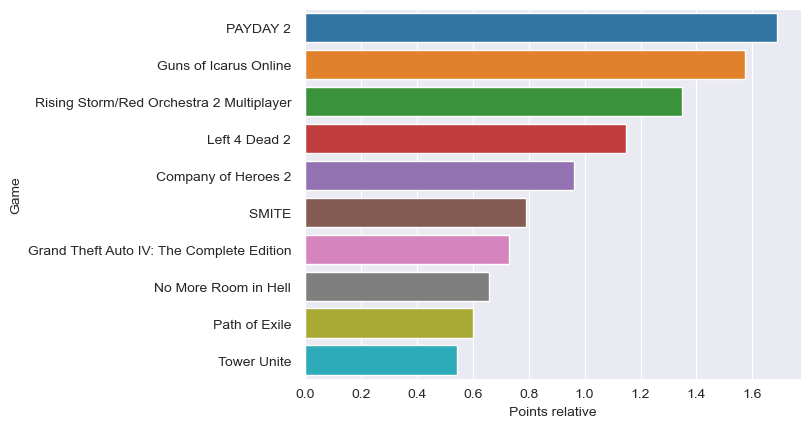

In [285]:
grouped_by_games["Points relative"] = (grouped_by_games["Points"] / grouped_by_games["Points"].sum())*100
grouped_by_games
sns.barplot(data=grouped_by_games.iloc[:10], x = "Points relative", y = grouped_by_games.iloc[:10].index)

As we now can see in the plot above, the first 4 games all have over 1% of the Points rewarded. In total the top ten games rewarded a little over 10% over the points in total. Some further analysis based on that could be to assess how many achievements there are for each game, how hard is it to get the achievements, etc. Unfortunately there is no data (in the present datasets). We still can count how many (best) achievement each game has.

In [286]:
unique_best_achievements = best_achievements_df.drop_duplicates(subset=["Achievement"])
unique_best_achievements = unique_best_achievements.sort_values(by="Points", ascending=False)
unique_best_achievements

,Achievement,Game,Points
615419,Agile Archery,SMITE,4.91
121740,Matched Play Commander Unlock,Natural Selection 2,4.84
860379,Captivating,Warface,4.78
860380,Bloody Nomad,Warface,4.78
860378,Hardcore Red spiders,Warface,4.78
...,...,...,...
1553413,"Which is more beautiful, me or the boss's wife?",恋爱关系/Romance - 夏季花火,0.04
609418,The Rookie,Forza Horizon 5: Hot Wheels,0.03
1553414,Tasting the poetry of summer's breeze,恋爱关系/Romance - 夏季花火,0.03
1553415,Prove it with action ......,恋爱关系/Romance - 夏季花火,0.02


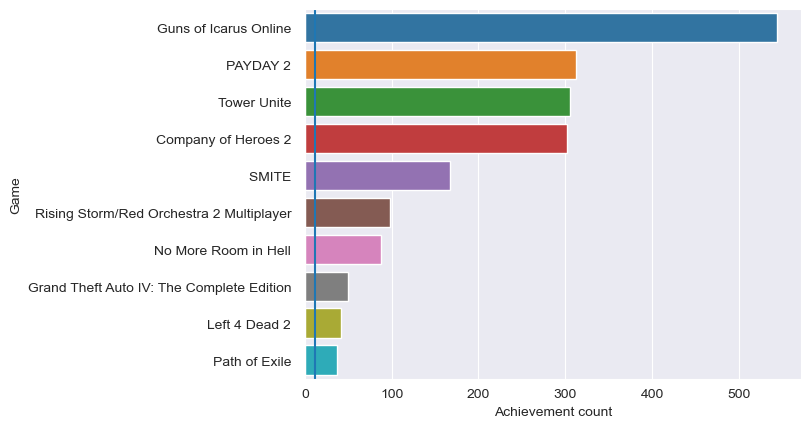

In [287]:
grouped_by_games["Achievement count"] = unique_best_achievements["Game"].value_counts()
grouped_by_games["Point mean per achievement"] = unique_best_achievements[["Game","Points"]].groupby(["Game"]).mean()
to_plot = grouped_by_games.iloc[:10]
to_plot = to_plot.sort_values(by="Achievement count", ascending=False)
graph = sns.barplot(data=to_plot, x = "Achievement count", y=to_plot.index)
graph.axvline(grouped_by_games["Achievement count"].mean())
plt.show()

Shown in the plot above, these are the game that rewarded the most points. The vertical line is the average of the `Achievement count` column. Hardly surprising is that every Game rewarded more than the average, but still vary quite a bit between each other. This is still not surprising, since each achievement rewards a different amount of points.

Summing this up, we can say that the questions are answered with the above analysis of the dataframe. By finding these facts one could go further in the analysis, but for that additional data is needed.

### 3.2 EDA player achievements
After we took a look at the best achievements from the players, we now take a look at the `achieve_df`. This dataset has way more data in total. Since we got more data overall, one could ask these questions:
- Have the best players older accounts?
- Have the top players have more hours played?
- Have the players with more points more game completed to a 100%?
- Have Players with a higher point-count more games in total?
- Has the amount of Badges something to do with the ranking?

In [288]:
achieve_df

,Rank,Player Id,Player Name,Best achievements,Points,Achievement amount,Games,100%,Badges,XP,Member since,Hours,Last update
0,1,The Stranger,The Stranger,[Blessing of the Flame (Your Chronicle – 2.82 ...,132759.30,153732,16755,4493,4910,3087192,2011-04-15,75591.8,05/26/2022 11:41:05
1,2,lylat,lylat,"[Death from Above (Rust – 3.77 points), Apex P...",119588.95,141645,18358,6034,195,296822,2009-06-03,55960.7,05/26/2022 11:42:01
2,3,hannez,hannez,"[Legendary Heckler (Nomad – 2.91 points), Lege...",96014.25,98255,13651,4008,2009,792032,2010-06-23,33020.0,05/26/2022 11:40:54
3,4,DDtective,DDtective,"[Escaping Outlands (Unturned – 3.61 points), A...",89515.41,101757,12070,3708,196,60662,2005-09-01,9352.9,07/22/2022 23:39:26
4,5,Skaery,Skaery,[World of Easy Goo (Kaiju-A-GoGo – 3.19 points...,88175.83,95676,10338,2127,645,198956,2004-06-08,89602.9,05/26/2022 11:38:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200005,200006,76561198085421589,Brandenburg800,[1v1 Ranked (all I got was stomped and this lo...,467.61,642,112,1,12,1852,2013-03-03,1544.3,06/05/2022 19:40:30
200006,200007,76561198403437459,bounce01,"[Who Need A Mechanic? (Besiege – 1.92 points),...",467.61,857,102,2,7,783,2017-07-11,2750.9,06/06/2022 20:56:55
200007,200008,76561198015047677,awake,"[I'm Flying! (Drake Hollow – 2.00 points), Jus...",467.61,908,190,1,125,31466,2009-11-01,0.0,05/21/2022 23:19:50
200008,200009,76561198832353988,depressed fearless,"[Welcome to Arid (Unturned – 2.15 points), NEW...",467.60,767,60,0,8,4946,2018-04-25,1512.8,04/24/2022 10:35:30


First, we drop the columns `Player Name`, `Best achievements` and `Last update`.

In [289]:
achieve_df_eda = achieve_df[["Rank", "Player Id", "Points", "Achievement amount", "Games", "100%", "Badges", "XP", "Member since", "Hours"]]
achieve_df_eda

,Rank,Player Id,Points,Achievement amount,Games,100%,Badges,XP,Member since,Hours
0,1,The Stranger,132759.30,153732,16755,4493,4910,3087192,2011-04-15,75591.8
1,2,lylat,119588.95,141645,18358,6034,195,296822,2009-06-03,55960.7
2,3,hannez,96014.25,98255,13651,4008,2009,792032,2010-06-23,33020.0
3,4,DDtective,89515.41,101757,12070,3708,196,60662,2005-09-01,9352.9
4,5,Skaery,88175.83,95676,10338,2127,645,198956,2004-06-08,89602.9
...,...,...,...,...,...,...,...,...,...,...
200005,200006,76561198085421589,467.61,642,112,1,12,1852,2013-03-03,1544.3
200006,200007,76561198403437459,467.61,857,102,2,7,783,2017-07-11,2750.9
200007,200008,76561198015047677,467.61,908,190,1,125,31466,2009-11-01,0.0
200008,200009,76561198832353988,467.60,767,60,0,8,4946,2018-04-25,1512.8


The first thing we can analyze is the `Member since` column. By this we can get information about when the accounts are created.

In [290]:
achieve_df_eda = achieve_df_eda[achieve_df_eda["Member since"]!="['Private profile']"]
achieve_df_eda["Year"] =  pd.DatetimeIndex(achieve_df_eda["Member since"]).year
int(achieve_df_eda["Year"].mean())

2011

In [291]:
top_30_df = achieve_df_eda.iloc[:100]
int(top_30_df["Year"].mean())

2009

By looking at the mean of the top 100 players and the overall mean, we can say that the top players have older accounts. This is not really meaningful, since players could be in the lower ranks because they haven't had a chance to play much. Hence, it is obvious that the mean is 2 years higher.

Now lets get an insight about the Question, if the top players have higher amounts of hours played. This seems to be logical so far, because to gain achievements you have to play games, and thus you have to spend more hours.

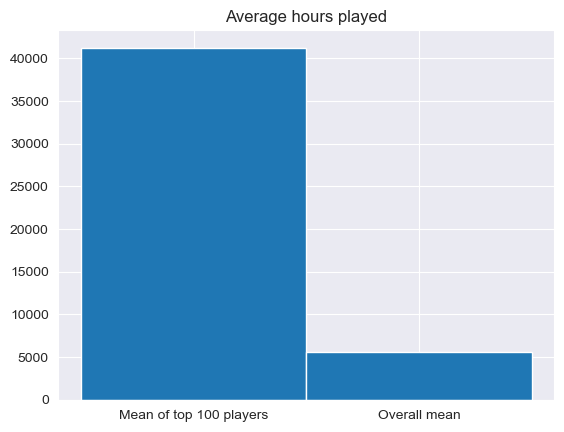

In [292]:
fig, ax  = plt.subplots()
ax.bar([1, 2], [achieve_df_eda["Hours"].iloc[:100].mean(), achieve_df_eda["Hours"].mean()], width=1,
       tick_label=['Mean of top 100 players', 'Overall mean'], align='center')
plt.title("Average hours played")
plt.show()

Based on the average hours overall and the average hours from the top 100 players we can see that the top 100 players have nearly 8 times the playtime than the average. By this it is safe to say, that the more hours the player has spent on playing, the more points he probably has over some other player with less time spent.

Next Question that came up is if the higher the rank is the more games are completed to 100%. This might be interesting in regard to the strategy of the players gaining XP. If you think about gaining XP you can come up with a "strategy". One might think, gaining every achievement in a game and thus completing it to 100%, could be more rewarding (in regard to XP) than buying/getting overall more games and try to get the "basic" achievements of these games. By basic achievements I mean the achievements you get for e.g. completing the tutorial, finishing the first chapter of the story, etc. To get a more accurate value I first calculated the rate of games completed (100%/games owned) and then used the describe method to analyse the results.

In [293]:
achieve_df_eda["Completion rate"] = ((achieve_df_eda["100%"]/achieve_df_eda["Games"])*100).round(2)
achieve_df_eda

,Rank,Player Id,Points,Achievement amount,Games,100%,Badges,XP,Member since,Hours,Year,Completion rate
0,1,The Stranger,132759.30,153732,16755,4493,4910,3087192,2011-04-15,75591.8,2011,26.82
1,2,lylat,119588.95,141645,18358,6034,195,296822,2009-06-03,55960.7,2009,32.87
2,3,hannez,96014.25,98255,13651,4008,2009,792032,2010-06-23,33020.0,2010,29.36
3,4,DDtective,89515.41,101757,12070,3708,196,60662,2005-09-01,9352.9,2005,30.72
4,5,Skaery,88175.83,95676,10338,2127,645,198956,2004-06-08,89602.9,2004,20.57
...,...,...,...,...,...,...,...,...,...,...,...,...
200005,200006,76561198085421589,467.61,642,112,1,12,1852,2013-03-03,1544.3,2013,0.89
200006,200007,76561198403437459,467.61,857,102,2,7,783,2017-07-11,2750.9,2017,1.96
200007,200008,76561198015047677,467.61,908,190,1,125,31466,2009-11-01,0.0,2009,0.53
200008,200009,76561198832353988,467.60,767,60,0,8,4946,2018-04-25,1512.8,2018,0.00


In [294]:
achieve_df_eda["Completion rate"].describe()

count    192288.000000
mean          6.301126
std          12.762049
min           0.000000
25%           0.570000
50%           1.780000
75%           5.710000
max        1400.000000
Name: Completion rate, dtype: float64

In [295]:
achieve_df_eda["Completion rate"].iloc[:100].describe()

count    100.000000
mean      26.494200
std       16.812779
min        2.920000
25%       13.670000
50%       24.815000
75%       34.910000
max       82.400000
Name: Completion rate, dtype: float64

Looking at both the values from the `describe` function, we first can see that we have values that are not adding up. A completion rate over 100% doesn't add up. Looking at these cases, my best guess is, that the profile was private at some points and then went public again. This could mess with the data. Luckily this only happened for 3 entries, and we can leave it like that. Overall, it is safe to say, that the top players have more games completed to 100% and therefore getting their points.

At last, I wanted to get some insights about the badges. It could be seen as obvious, that the players with more points have more badges, since you need to play the games to gain achievements and badges. After looking more into the way badges are earned, I found out sometimes it is possible to gain trading cards and thus badges by spending money in a game. So, yet again, I decided to look at the mean of the top 100 players and the overall players in the dataframe.

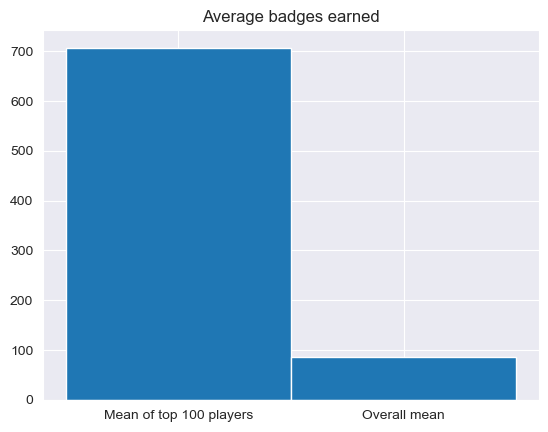

In [296]:
fig, ax  = plt.subplots()
ax.bar([1, 2], [achieve_df_eda["Badges"].iloc[:100].mean(), achieve_df_eda["Badges"].mean()], width=1,
       tick_label=['Mean of top 100 players', 'Overall mean'], align='center')
plt.title("Average badges earned")
plt.show()

This plot looks quite similar to the *average hours played* plot. By looking at this plot, it can be assumed that the higher a player is in rank, the more badges he has earned in general.

With the answering of these questions the EDA of the `achievement_df` is finished. This gives a good overview of what the data represents and how different amounts of value can be assigned to different players in regard to their rank.

### 3.3 EDA achievements by country
In this part of the EDA we take a look at the `country_df`. Questions one could ask here are:
- What are the top countries in case of achievement gains?
- What players from which country perform best (average)?

In [297]:
country_df

,Rank,Players,Points,Number,Games,Badges,XP,Hours,Country
0,1,135643,86532124.75,137664177,31410891,5453964,2252121996,412471186.4,Unknown
1,2,59698,52132889.98,84410455,20379201,2569218,974895706,236137390.5,United States
2,3,31058,24753943.31,37279292,7247856,1657378,693424533,104656082.0,Russian Federation
3,4,21750,18214362.15,28423805,6658939,1381807,590848431,86523185.4,Germany
4,5,16225,15635912.83,25101789,5780703,786975,294574732,68131144.6,United Kingdom (Great Britain)
...,...,...,...,...,...,...,...,...,...
247,248,8,3504.34,6295,1664,201,106549,17584.0,Malawi
248,249,10,3231.50,5663,788,144,43292,24574.4,Mauritania
249,250,7,2587.67,5310,1100,81,16709,20665.0,French Guiana
250,251,14,2089.76,4749,626,116,21427,18169.2,Anguilla


In [298]:
country_df["Players"].iloc[0]/country_df["Players"].sum()

0.2919577785526412

The first row represents the data of the players who have no country displayed on their profile. This is the case for roughly 30% of the players. Because we cannot really analyze that data I decided to just drop it. Following, we can determine the top (10) countries.

In [299]:
country_df = country_df.iloc[1: , :]


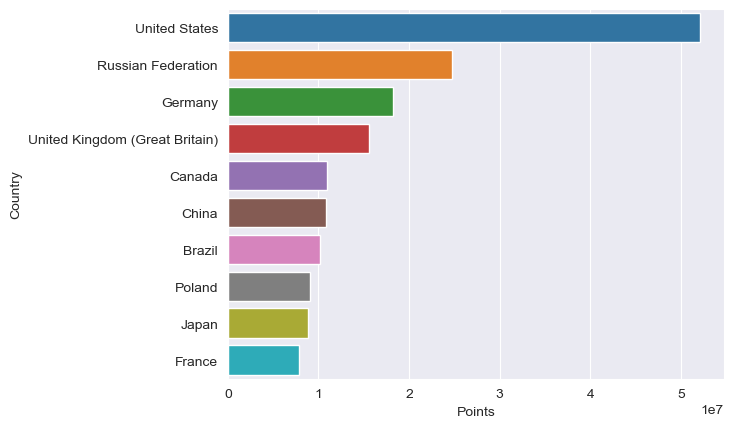

In [300]:
country_df_plot = country_df[["Country", "Points"]].iloc[:10]
plot = sns.barplot(data=country_df_plot, x= country_df.Points, y=country_df_plot.Country)

As shown in the plot above, the top country based on points is the USA. Followed with half it's points is Russia, closely followed by Germany. This is only based on the overall points, which means if a country has more players than the others it has an advantage with their points count. To evaluate the countries even more, we could average the points, XP, badges, etc. on the players of each country. By doing this, it is possible to evaluate which country has the best players.

In [301]:
columns = [["Points", "Number", "Games", "Badges", "XP", "Hours"]]
country_df_avg = country_df
for c in country_df_avg[["Points", "Number", "Games", "Badges", "XP", "Hours"]]:
    country_df_avg[c] = country_df_avg[c]/ country_df_avg["Players"]

In [302]:
country_df_avg = country_df_avg.sort_values(by="Rank")
country_df_avg_top10 = country_df_avg.iloc[:10]
country_df_avg_top10

,Rank,Players,Points,Number,Games,Badges,XP,Hours,Country
1,2,59698,873.276994,1413.957838,341.371587,43.036919,16330.458407,3955.532690,United States
2,3,31058,797.023096,1200.312061,233.365188,53.363964,22326.760674,3369.698049,Russian Federation
3,4,21750,837.441938,1306.841609,306.158115,63.531356,27165.445103,3978.077490,Germany
4,5,16225,963.692624,1547.105639,356.283698,48.503852,18155.607519,4199.146046,United Kingdom (Great Britain)
5,6,12483,881.120860,1396.787952,321.467596,48.586237,19160.017143,3953.754330,Canada
6,7,15605,695.112763,1098.263826,395.299712,70.521307,32452.285998,3513.192169,China
7,8,15569,651.092509,1038.803841,251.688997,49.764339,15873.372792,3478.554788,Brazil
8,9,11358,799.931897,1215.198186,275.038211,46.057140,15696.333597,3448.120849,Poland
9,10,9548,921.904951,1376.538542,348.589024,73.131232,27782.872015,4059.113354,Japan
10,11,7675,1018.508352,1512.946189,307.865928,50.088730,16952.159739,3868.678176,France


<AxesSubplot:xlabel='Points', ylabel='Country'>

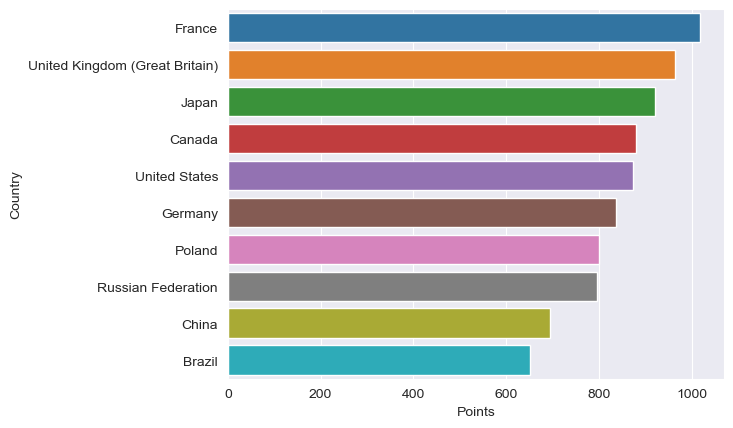

In [303]:
country_df_avg_top10 = country_df_avg_top10.sort_values(by="Points", ascending=False)
sns.barplot(data=country_df_avg_top10[["Points", "Country"]], x= country_df_avg_top10.Points, y= country_df_avg_top10.Country)

If we now compare the two plots to each other, we can see that the order changed in nearly every aspect. Thus, we can say that some countries got players that gain more points in average and be more effective in that way, but since the player base is smaller, the country cannot add up the numbers to countries with a much higher player count.

## 4. Modelling

After the EDA is finished we can do some Modelling. I decided to do a basic linear regression model and try to predict the players rank based on their values. First, we normalize the values we want to use for the model.

In [304]:
columns = ["Points", "Achievement amount", "Games", "100%", "Badges", "XP", "Hours", "Year", "Completion rate"]
achieve_df_eda[columns] = (achieve_df_eda[columns]-achieve_df_eda[columns].min())/(achieve_df_eda[columns].max()-achieve_df_eda[columns].min())

In [305]:
achieve_df_eda

,Rank,Player Id,Points,Achievement amount,Games,100%,Badges,XP,Member since,Hours,Year,Completion rate
0,1,The Stranger,1.000000e+00,1.000000,0.674287,0.744614,0.251847,0.084152,2011-04-15,0.064415,0.421053,0.019157
1,2,lylat,9.004446e-01,0.921253,0.738801,1.000000,0.010002,0.008091,2009-06-03,0.047687,0.315789,0.023479
2,3,hannez,7.222422e-01,0.638565,0.549362,0.664236,0.103047,0.021590,2010-06-23,0.028138,0.368421,0.020971
3,4,DDtective,6.731171e-01,0.661381,0.485733,0.614518,0.010053,0.001654,2005-09-01,0.007970,0.105263,0.021943
4,5,Skaery,6.629912e-01,0.621763,0.416026,0.352502,0.033084,0.005423,2004-06-08,0.076355,0.052632,0.014693
...,...,...,...,...,...,...,...,...,...,...,...,...
200005,200006,76561198085421589,7.559053e-08,0.002613,0.004467,0.000166,0.000616,0.000050,2013-03-03,0.001316,0.526316,0.000636
200006,200007,76561198403437459,7.559053e-08,0.004013,0.004065,0.000331,0.000359,0.000021,2017-07-11,0.002344,0.736842,0.001400
200007,200008,76561198015047677,7.559053e-08,0.004346,0.007607,0.000166,0.006412,0.000858,2009-11-01,0.000000,0.315789,0.000379
200008,200009,76561198832353988,0.000000e+00,0.003427,0.002375,0.000000,0.000410,0.000135,2018-04-25,0.001289,0.789474,0.000000


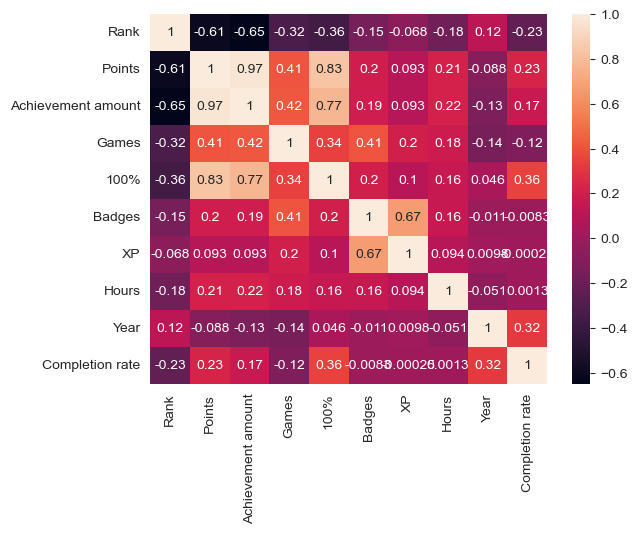

In [306]:
sns.heatmap(achieve_df_eda.corr(), annot=True)
plt.show()

As we can see in the heatmap there are some strong correlations between some of these values. This indicates that there could be some patterns. These patterns could be useful for trying to predict something. In this case we want to predict the Rank based on the values we normalized. The common way to do that is a regression model. In terms of prediction values I decided to look at a steam profile to check which information one could gain quite easily. These can be found in the `X`-List in the cell below.


In [307]:
X = achieve_df_eda[["Achievement amount", "XP", "Year", "100%", "Hours", "Badges"]]
y = achieve_df_eda["Rank"]

#train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101)

In [308]:
#create LinearRegression model
model = LinearRegression()

In [309]:
#training the model
model.fit(X_train, y_train)

LinearRegression()

In [310]:
prediction = model.predict(X_test)

In [311]:
"The accuracy of the model is {} with a mean squared error of {}.".format(r2_score(y_test, prediction), mean_squared_error(y_test, prediction))

'The accuracy of the model is 0.4871226677150641 with a mean squared error of 1711155889.3652976.'

With just the values we gave the model, we can guess the rank of the player with an accuracy of around 50% with a linear regression model. Another approach could be a random forest algorithm. This model could have a higher accuracy since it usually works better with low correlation than the linear regression.

In [314]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
prediction_rf = model_rf.predict(X_test)
"The accuracy of the model is {}.".format(r2_score(y_test, prediction_rf))

'The accuracy of the model is 0.930703205272108.'

Looking at the accuracy score, we can see that the random forest model can predict the rank way more accurate. We get an accuracy that is around 93%! The accuracy came with the cost of higher processing costs. With the system running this notebook it took about 30 seconds, which is not that much. We can still try to increase the accuracy with increasing the `n_estimators` of the random forest model. I increased it from the default 100 to 1000. This increased the compilation time to around 10 minutes and didn't really increase the accuracy. That is way I decided to stick to the default 100 `n_estimators`.

In [ ]:
#model_rf = RandomForestRegressor(n_estimators=1000)
#model_rf.fit(X_train, y_train)
#prediction_rf = model_rf.predict(X_test)
#"The accuracy of the model is {}.".format(r2_score(y_test))